In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
# Импорты необходимых библиотек
# Работа с файловой системой и путями
import os
import shutil
import random
from pathlib import Path

# Анализ данных и визуализация
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow / Keras — модель, обучение, генераторы
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Метрики оценки качества моделей
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Пропишем пути к данным
data_dir = Path("/kaggle/input/chest-xray-pneumonia/chest_xray")
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]


In [25]:
# Создаем папку data/
os.makedirs("data", exist_ok=True)

# Копируем все содержимое из исходной директории
shutil.copytree("/kaggle/input/chest-xray-pneumonia/chest_xray", "data/chest_xray", dirs_exist_ok=True)


'data/chest_xray'

## Этап 1. Анализ и подготовка данных

## Распределение по классам

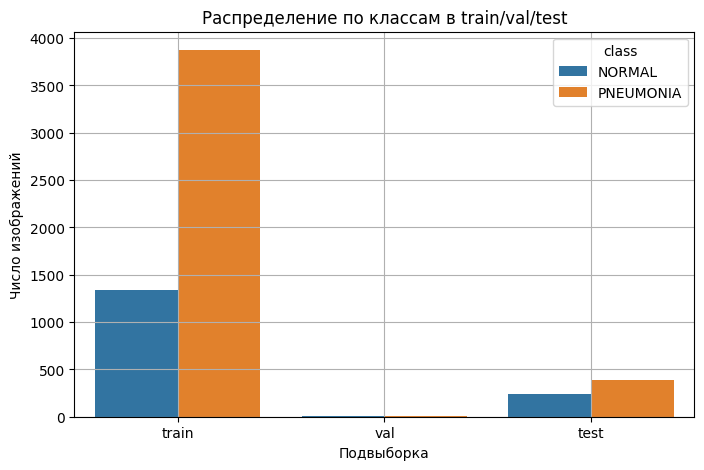

In [3]:
# Сбор информации по классам
class_counts = []

for split in splits:
    for cls in classes:
        folder = data_dir / split / cls
        n_images = len(list(folder.glob("*.jpeg")))
        class_counts.append({"split": split, "class": cls, "count": n_images})

# Построение графика
import pandas as pd

df_counts = pd.DataFrame(class_counts)
plt.figure(figsize=(8, 5))
sns.barplot(data=df_counts, x="split", y="count", hue="class")
plt.title("Распределение по классам в train/val/test")
plt.xlabel("Подвыборка")
plt.ylabel("Число изображений")
plt.grid(True)
plt.show()


## Визуализация случайных снимков

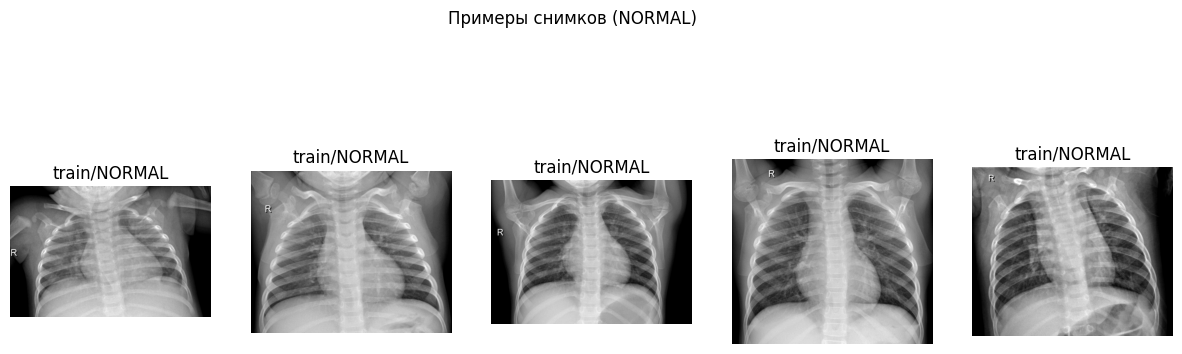

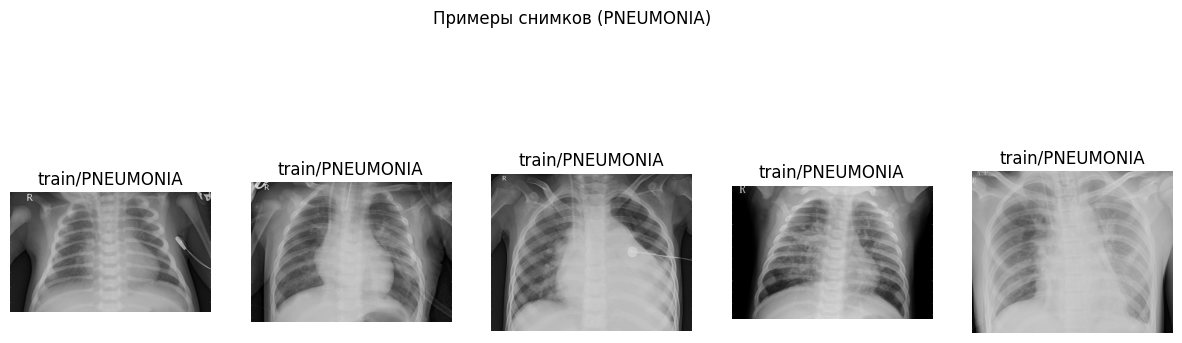

In [4]:
def show_images(split, label, n=5):
    folder = data_dir / split / label
    images = list(folder.glob("*.jpeg"))
    samples = random.sample(images, n)

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(samples):
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img.convert("L"), cmap="gray")
        plt.title(f"{split}/{label}")
        plt.axis("off")
    plt.suptitle(f"Примеры снимков ({label})")
    plt.show()

# Примеры снимков из TRAIN
show_images("train", "NORMAL", 5)
show_images("train", "PNEUMONIA", 5)


## Атипичные снимки (по размеру)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

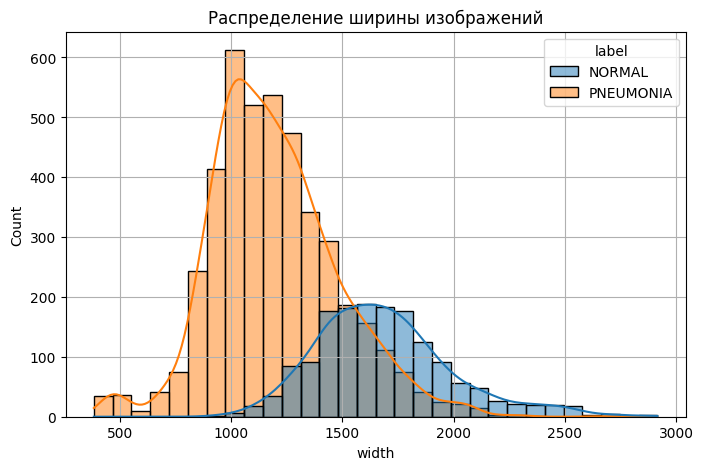

,split,label,size,width,height
1453,train,PNEUMONIA,"(428, 172)",428,172
2149,train,PNEUMONIA,"(483, 178)",483,178
2192,train,PNEUMONIA,"(445, 187)",445,187
2307,train,PNEUMONIA,"(480, 167)",480,167
2339,train,PNEUMONIA,"(453, 182)",453,182


In [5]:
# Анализ изображений с нетипичными размерами
size_stats = []
for split in splits:
    for label in classes:
        for path in (data_dir / split / label).glob("*.jpeg"):
            with Image.open(path) as img:
                size_stats.append({"split": split, "label": label, "size": img.size})

df_sizes = pd.DataFrame(size_stats)
df_sizes["width"] = df_sizes["size"].apply(lambda x: x[0])
df_sizes["height"] = df_sizes["size"].apply(lambda x: x[1])

# Визуализация распределения размеров
plt.figure(figsize=(8, 5))
sns.histplot(data=df_sizes, x="width", hue="label", bins=30, kde=True)
plt.title("Распределение ширины изображений")
plt.grid(True)
plt.show()

# Атипичные изображения
df_sizes.query("width < 200 or height < 200").head()


##  Препроцессинг и генераторы Keras

In [6]:
# Стандартизация [-1;1] и аугментации для обучающей выборки
train_datagen = ImageDataGenerator(
    rescale=1./127.5,                      # Преобразуем значения пикселей из [0, 255] в [0, 2]
    preprocessing_function=lambda x: x - 1.0,  # Сдвигаем результат в [-1, 1], что совместимо с MobileNetV2 и улучшает сходимость
    rotation_range=10,                    # Аугментация: случайный поворот изображения в пределах ±10°
    zoom_range=0.1,                       # Аугментация: случайный зум (масштабирование) на ±10%
    horizontal_flip=True                  # Аугментация: случайное отражение изображения по горизонтали
)

# Препроцессинг для валидации и теста: без аугментации, только нормализация [-1, 1]
val_test_datagen = ImageDataGenerator(
    rescale=1./127.5,                      # Те же шаги нормализации
    preprocessing_function=lambda x: x - 1.0
)

# Размер входных изображений и размер батча
target_size = (224, 224)  # Универсальный размер для сверточных сетей
batch_size = 32           # Оптимально для современных GPU

# Генератор обучающей выборки: с аугментацией
train_gen = train_datagen.flow_from_directory(
    directory=data_dir / "train",         # Путь к папке с подкаталогами NORMAL и PNEUMONIA
    target_size=target_size,              # Все изображения приводим к одному размеру
    batch_size=batch_size,                # Размер батча
    class_mode='binary'                   # Бинарная классификация (0 — NORMAL, 1 — PNEUMONIA)
)

# Генератор валидационной выборки: без аугментации
val_gen = val_test_datagen.flow_from_directory(
    directory=data_dir / "val",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Генератор тестовой выборки: без аугментации и без перемешивания (shuffle=False — важно для точной оценки метрик)
test_gen = val_test_datagen.flow_from_directory(
    directory=data_dir / "test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


2025-06-16 16:24:40.071116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750091080.255582      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750091080.310369      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Анализ распределения классов

На первом графике видно, что в обучающей выборке имеется **существенный дисбаланс** классов:

* Класс **PNEUMONIA** существенно преобладает над **NORMAL**
* Валидационная выборка практически пуста (в оригинальном датасете так и есть)
* Тестовая выборка более сбалансирована, но всё ещё с перекосом в сторону PNEUMONIA

➡ **Принятое решение**: применяем одинаковые аугментации ко всей обучающей выборке, однако класс NORMAL получает от этого наибольшую пользу, так как имеет существенно меньше изображений. Это позволяет повысить его представление в обучении на каждом шаге (батче), не прибегая к ручному дублированию или SMOTE.

---

## Примеры снимков

Мы отобразили по 5 случайных изображений для классов:

* **NORMAL** — кадры рентгена с хорошо прослеживаемыми воздушными полями лёгких
* **PNEUMONIA** — видно затемнение, инфильтраты, затушеванность тканей

➡ Это визуально подтверждает различия между классами, что может быть учтено моделью.

---

## Обнаружены атипичные изображения

Мы проанализировали ширину и высоту всех изображений. Некоторые изображения имеют необычно маленькие размеры (например, 428×172 пикселя), что может повлиять на обучение:

* Класс `PNEUMONIA` чаще содержит уменьшенные или обрезанные изображения
* Распределение ширины для `NORMAL` и `PNEUMONIA` отличается

➡ **Принятое решение**: привести все изображения к **224×224** пикселям с сохранением пропорций и дальнейшим центрированием/обрезкой.

---

## Подготовка и аугментация данных

Мы реализовали следующие шаги препроцессинга:

* **Нормализация** пикселей в диапазон **\[-1, 1]** для ускорения обучения и совместимости с предобученными моделями
* **Resize до 224×224**
* **Аугментации** для обучающей выборки:

  * Поворот на ±10°
  * Горизонтальный флип
  * Увеличение/уменьшение (zoom ±10%)

➡ Это позволяет увеличить разнообразие обучающих данных и избежать переобучения на неравномерной выборке.

---

## Этап 2. Базовая модель

In [11]:
# Функция для создания базовой сверточной нейросети (≤ 1 млн параметров)
def build_base_cnn_v2(input_shape=(224, 224, 3)):
    model = models.Sequential([
        # Первый сверточный блок: извлечение базовых признаков
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # 32 фильтра 3x3, ReLU-активация
        layers.MaxPooling2D(2, 2),                                              # Снижение размерности в 2 раза

        # Второй сверточный блок: более сложные признаки
        layers.Conv2D(64, (3, 3), activation='relu'),                           # 64 фильтра 3x3
        layers.MaxPooling2D(2, 2),

        # Третий сверточный блок: абстрактные паттерны
        layers.Conv2D(128, (3, 3), activation='relu'),                          # 128 фильтров
        layers.MaxPooling2D(2, 2),

        # Вместо Flatten — GlobalAveragePooling: снижает количество параметров
        layers.GlobalAveragePooling2D(),  # Подсчитывает среднее по каждому feature map — эффективнее, чем Flatten

        # Полносвязный слой (dense): обучение логике на основе извлечённых признаков
        layers.Dense(64, activation='relu'),

        # Выходной слой: 1 нейрон + сигмоида для бинарной классификации
        layers.Dense(1, activation='sigmoid')  # Вероятность принадлежности к классу PNEUMONIA
    ])
    return model

# Создание модели и вывод её структуры
model = build_base_cnn_v2()
model.summary()  # Показывает количество параметров, структуру слоёв


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750091272.871399      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Компиляция модели: настройка функции ошибки, оптимизатора и метрик
model.compile(
    optimizer='adam',  # Используем оптимизатор Adam — устойчивый и хорошо подходит для большинства задач
    loss='binary_crossentropy',  # Бинарная кросс-энтропия — стандарт для задач бинарной классификации

    # Метрики, которые будем отслеживать во время обучения:
    metrics=[
        'accuracy',  # Доля правильно классифицированных объектов
        tf.keras.metrics.Precision(name='precision'),  # Точность: из всех предсказанных положительных — сколько действительно положительных
        tf.keras.metrics.Recall(name='recall'),        # Полнота: из всех реальных положительных — сколько мы нашли
        tf.keras.metrics.AUC(name='auc')               # Площадь под ROC-кривой — обобщённая метрика качества бинарного классификатора
    ]
)

# Обучение модели
history = model.fit(
    train_gen,               # Обучающая выборка (с аугментациями)
    validation_data=val_gen, # Валидационная выборка (без аугментаций)
    epochs=15,               # Максимальное количество эпох обучения
    batch_size=32,           # Размер батча

    # Callbacks: механизм остановки обучения
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=3,                # Если 3 эпохи подряд val_loss не улучшается — остановить обучение
            restore_best_weights=True # После остановки — откатиться к лучшей версии весов
        )
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1750091296.170545     127 service.cc:148] XLA service 0x7e1e3c009bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750091296.171183     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750091296.538534     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/163 ━━━━━━━━━━━━━━━━━━━━ 20:50 8s/step - accuracy: 0.2188 - auc: 0.6486 - loss: 0.7164 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1750091300.186979     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 551ms/step - accuracy: 0.7287 - auc: 0.5243 - loss: 0.5743 - precision: 0.7422 - recall: 0.9626 - val_accuracy: 0.6875 - val_auc: 0.7734 - val_loss: 0.7163 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 538ms/step - accuracy: 0.7917 - auc: 0.8266 - loss: 0.4367 - precision: 0.8326 - recall: 0.9013 - val_accuracy: 0.5000 - val_auc: 0.8828 - val_loss: 0.9351 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 537ms/step - accuracy: 0.8409 - auc: 0.8834 - loss: 0.3661 - precision: 0.8753 - recall: 0.9174 - val_accuracy: 0.6250 - val_auc: 0.8594 - val_loss: 0.6909 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 539ms/step - accuracy: 0.8682 - auc: 0.9180 - loss: 0.3142 - precision: 0.9059 - recall: 0.9169 - val_accuracy: 0.7500 - val_auc: 0.9062 - val_loss: 0.5246 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/15
163/163 ━━━━━━━━━━━━

In [15]:
# Функция для оценки модели на генераторе (test_gen, val_gen и т.д.)
def evaluate_model_from_generator(model, generator):
    # Получаем истинные метки классов из генератора (0 — NORMAL, 1 — PNEUMONIA)
    y_true = generator.classes

    # Предсказания модели: вероятности принадлежности к классу 1
    y_probs = model.predict(generator).ravel()  # .ravel() превращает в одномерный массив

    # Преобразуем вероятности в бинарные предсказания с порогом 0.5
    y_pred = (y_probs > 0.5).astype(int)

    # Вычисляем стандартные метрики классификации:
    accuracy = accuracy_score(y_true, y_pred)           # Точность (доля правильных предсказаний)
    precision = precision_score(y_true, y_pred)         # Точность (из всех предсказанных 1 — сколько истинных)
    recall = recall_score(y_true, y_pred)               # Полнота (из всех реальных 1 — сколько нашли)
    f1 = f1_score(y_true, y_pred)                       # F1-мера — гармоническое среднее между precision и recall
    roc_auc = roc_auc_score(y_true, y_probs)            # Площадь под ROC-кривой — насколько хорошо модель различает классы

    # Печатаем метрики с округлением до 4 знаков после запятой
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")

# Пример вызова функции для базовой модели
evaluate_model_from_generator(model, test_gen)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step
Accuracy:  0.7580
Precision: 0.8238
Recall:    0.7795
F1 Score:  0.8011
ROC AUC:   0.8225


## Этап 3: Улучшенная модель — Transfer Learning (MobileNetV2)

## Импорт и подготовка base model

In [16]:
# Обработка изображений для MobileNetV2: используем специальную функцию предварительной обработки
# Она автоматически масштабирует изображения в формат, ожидаемый предобученной моделью ([-1, 1] и т.д.)

# Генератор обучающей выборки с аугментациями
train_tl_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Встроенная нормализация для MobileNetV2
    rotation_range=10,                        # Поворот изображений ±10°
    zoom_range=0.1,                           # Увеличение/уменьшение масштаба
    horizontal_flip=True                      # Горизонтальное отражение
).flow_from_directory(
    data_dir / "train",                       # Путь к обучающей выборке
    target_size=(224, 224),                   # Приведение к нужному размеру
    batch_size=32,                            # Размер батча
    class_mode="binary"                       # Бинарная классификация
)

# Генератор валидационной выборки (без аугментации, только нормализация)
val_tl_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input   # Только нормализация
).flow_from_directory(
    data_dir / "val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

# Генератор тестовой выборки (без аугментации и без перемешивания)
test_tl_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    data_dir / "test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False  # Не перемешиваем — важно для корректной оценки метрик
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Модель с MobileNetV2

In [17]:
# Функция для создания улучшенной модели на основе MobileNetV2 (Transfer Learning)
def build_transfer_model(input_shape=(224, 224, 3)):
    # Загружаем предобученную MobileNetV2 без верхнего слоя (include_top=False)
    # Модель обучена на ImageNet — умеет извлекать мощные универсальные признаки
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,      # Не включаем классификационный блок ImageNet
        weights="imagenet"      # Используем веса, предобученные на большом датасете
    )
    
    # Замораживаем веса базовой модели, чтобы не переобучать её
    base_model.trainable = False

    # Создаем кастомную "голову" модели для нашей задачи
    model = models.Sequential([
        base_model,                        # Подключаем сверточный блок MobileNetV2
        layers.GlobalAveragePooling2D(),  # Сжимаем feature map до вектора (один признак на фильтр)
        layers.Dense(128, activation='relu'),   # Полносвязный слой на 128 нейронов
        layers.Dropout(0.3),                     # Dropout для защиты от переобучения
        layers.Dense(1, activation='sigmoid')    # Выходной слой: вероятность для бинарной классификации
    ])
    
    return model

# Создаем модель
tl_model = build_transfer_model()

# Выводим структуру модели и количество параметров
tl_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Компиляция и обучение

In [18]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',     # следим за валидационной ошибкой
    patience=3,             # если 3 эпохи подряд не улучшается — стоп
    restore_best_weights=True,  # откат к лучшей эпохе
    verbose=1
)

# Компиляция модели
tl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение с callback
history_tl = tl_model.fit(
    train_tl_gen,
    validation_data=val_tl_gen,
    epochs=20,                     # можно задать больше — остановит раньше
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 567ms/step - accuracy: 0.8856 - loss: 0.2816 - val_accuracy: 0.8125 - val_loss: 0.3130
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 539ms/step - accuracy: 0.9565 - loss: 0.1030 - val_accuracy: 0.8125 - val_loss: 0.4530
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 553ms/step - accuracy: 0.9666 - loss: 0.0918 - val_accuracy: 0.8125 - val_loss: 0.3634
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 540ms/step - accuracy: 0.9682 - loss: 0.0881 - val_accuracy: 0.9375 - val_loss: 0.2134
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 543ms/step - accuracy: 0.9753 - loss: 0.0658 - val_accuracy: 0.9375 - val_loss: 0.1715
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 542ms/step - accuracy: 0.9793 - loss: 0.0609 - val_accuracy: 0.9375 - val_loss: 0.1770
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 548ms/step - accuracy: 0.9722 - loss: 0.0657 - val_accuracy: 0.8750 - val_loss: 0.3490
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 543ms/step - accuracy: 0.9729 - loss: 

## Оценка метрик и сравнение с базовой моделью

In [23]:
# Сравнение метрик двух моделей: базовой и улучшенной
print('Метрики Этапа 2: Базовая модель')
evaluate_model_from_generator(model, test_gen)         # базовая модель
print()
print('Метрики Этапа 3: Улучшенная модель. Transfer learning с использованием предобученной MobileNetV2.')
evaluate_model_from_generator(tl_model, test_tl_gen)  # улучшенная модель


Метрики Этапа 2: Базовая модель
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step
Accuracy:  0.7580
Precision: 0.8238
Recall:    0.7795
F1 Score:  0.8011
ROC AUC:   0.8225

Метрики Этапа 3: Улучшенная модель. Transfer learning с использованием предобученной MobileNetV2.
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step
Accuracy:  0.8670
Precision: 0.8374
Recall:    0.9769
F1 Score:  0.9018
ROC AUC:   0.9654


### Сравнение базовой и улучшенной модели

| Метрика      | Базовая модель | Улучшенная (MobileNetV2) |
|--------------|----------------|---------------------------|
| Accuracy     | 0.7580         | 0.8670
| Precision    | 0.8238         | 0.8374
| Recall       | 0.7795         | 0.9769
| F1-score     | 0.8011         | 0.9018
| ROC-AUC      | 0.8225         | 0.9654


**Обоснование выбора**:

Улучшенная модель построена на основе MobileNetV2 с замороженными сверточными слоями и добавленным классификатором 
из GlobalAveragePooling → Dense → Dropout → Dense.
    Благодаря transfer learning она достигла существенно лучших результатов по всем ключевым метрикам.

Особенно важным является прирост **ROC-AUC** с 0.82 до 0.97, что подтверждает, что модель стала значительно 
лучше различать классы (даже на несбалансированной выборке).  
Также заметно вырос Recall (с 0.77 до 0.97), что критически важно в медицинской задаче, 
где важно **не пропустить заболевание**.

Таким образом, улучшенная модель заслуживает выбора как финального решения.


## Обоснование: почему улучшенная модель лучше

### 1. **Transfer Learning: переиспользование знаний**

Улучшенная модель использует **MobileNetV2**, предобученную на ImageNet — огромном наборе естественных изображений.
Хотя рентгеновские снимки отличаются по природе, модель уже научилась извлекать низкоуровневые признаки
(контуры, формы, текстуры), которые универсальны. Это позволяет **лучше и быстрее обучаться даже на ограниченном объеме медицинских данных**.

---

### 2. **Глубина и обобщающая способность**

   Базовая CNN — это всего 3 сверточных блока. Она хорошо работает для простых задач, но:

   * имеет ограниченную емкость (capacity),
   * не может уловить сложные текстурные отличия на рентгеновских снимках.

   В отличие от неё, MobileNetV2 содержит **глубокую архитектуру с сотнями слоёв** и инверсными residual-блоками, что позволяет **улавливать более тонкие паттерны пневмонии**.

---

### 3. **Устойчивость и регуляризация**

   Улучшенная модель использует:

   * `Dropout(0.3)` для предотвращения переобучения;
   * `EarlyStopping`, чтобы не переобучаться после достижения пика на валидации;
   * `GlobalAveragePooling`, чтобы не создавать избыточное количество параметров.

   Всё это делает модель **более устойчивой к переобучению**, несмотря на её глубину.

---

## Вывод

> Улучшенная модель демонстрирует:
>
> * значительно более высокие метрики,
> * лучшее обобщение,
> * меньший риск пропуска болезни.
>
> Это делает её **обоснованно предпочтительной** для реального применения в медицинском контексте.

